In [1]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-macosx_10_16_x86_64.whl (53.9 MB)


In [1]:
import tensorflow as tf
import os

/Users/anikait/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')


[]

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'Data/Images' 


In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']


In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory(directory = data_dir ,label_mode = 'categorical',color_mode = "grayscale",image_size =(63, 63) )

Found 637 files belonging to 4 classes.


In [10]:
iterator = data.as_numpy_iterator()


In [11]:
batch = iterator.next()

/Users/anikait/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


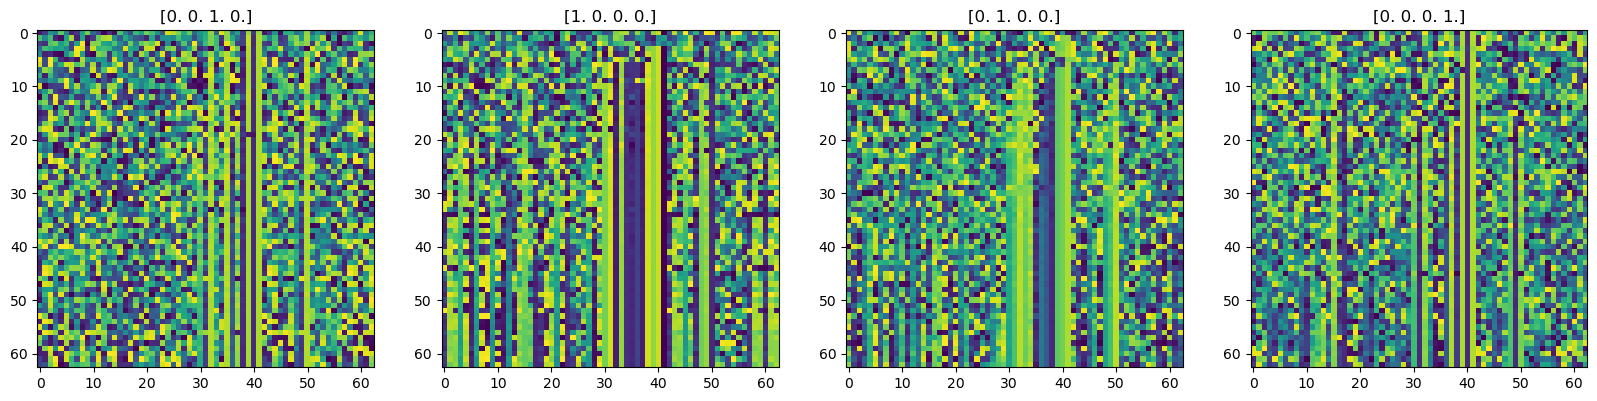

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
data = data.map(lambda x,y: (x/255, y))


In [14]:
data.as_numpy_iterator().next()


(array([[[[0.22352941],
          [0.78431374],
          [0.79607844],
          ...,
          [0.8117647 ],
          [0.3529412 ],
          [0.25490198]],
 
         [[0.41568628],
          [0.9098039 ],
          [0.50980395],
          ...,
          [0.85882354],
          [0.69803923],
          [0.8392157 ]],
 
         [[0.34901962],
          [0.18431373],
          [0.5568628 ],
          ...,
          [0.07450981],
          [0.6666667 ],
          [0.7176471 ]],
 
         ...,
 
         [[0.13333334],
          [0.8235294 ],
          [0.9019608 ],
          ...,
          [0.8745098 ],
          [0.94509804],
          [0.18039216]],
 
         [[0.05098039],
          [0.8862745 ],
          [0.8745098 ],
          ...,
          [0.8392157 ],
          [0.14117648],
          [0.10196079]],
 
         [[0.12156863],
          [0.85882354],
          [0.8980392 ],
          ...,
          [0.8784314 ],
          [0.03921569],
          [0.14509805]]],
 
 
        [

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size


14

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [18]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 63, 63, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(63,63,1)))
model.add(MaxPooling2D())
model.add(
    Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [22]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])


In [23]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 16)         0

In [24]:
for layer in model.layers:
    print(layer.output_shape)

(None, 61, 61, 16)
(None, 30, 30, 16)
(None, 28, 28, 32)
(None, 14, 14, 32)
(None, 12, 12, 16)
(None, 6, 6, 16)
(None, 576)
(None, 256)
(None, 4)


In [25]:
logdir='logs'


In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


In [27]:
hist = model.fit(train, epochs=32, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/32
14/14 [==============================] - 1s 30ms/step - loss: 1.4018 - accuracy: 0.2500 - val_loss: 1.3880 - val_accuracy: 0.2344
Epoch 2/32
14/14 [==============================] - 0s 25ms/step - loss: 1.3868 - accuracy: 0.2388 - val_loss: 1.3859 - val_accuracy: 0.2578
Epoch 3/32
14/14 [==============================] - 0s 23ms/step - loss: 1.3850 - accuracy: 0.2679 - val_loss: 1.3909 - val_accuracy: 0.2734
Epoch 4/32
14/14 [==============================] - 0s 24ms/step - loss: 1.3857 - accuracy: 0.2589 - val_loss: 1.3858 - val_accuracy: 0.2344
Epoch 5/32
14/14 [==============================] - 0s 26ms/step - loss: 1.3827 - accuracy: 0.2924 - val_loss: 1.3861 - val_accuracy: 0.2578
Epoch 6/32
14/14 [==============================] - 0s 29ms/step - loss: 1.3828 - accuracy: 0.2969 - val_loss: 1.3801 - val_accuracy: 0.2891
Epoch 7/32
14/14 [==============================] - 0s 31ms/step - loss: 1.3806 - accuracy: 0.2790 - val_loss: 1.3809 - val_accuracy: 0.2266
Epoch 8/32
14

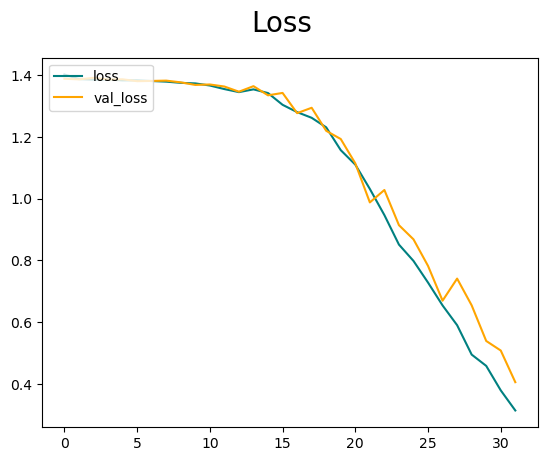

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

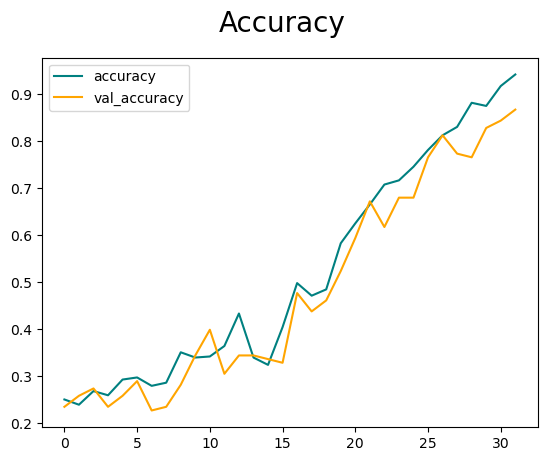

In [29]:

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [30]:
from tensorflow.keras.metrics import Precision, Recall,CategoricalAccuracy


In [31]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    print(len(batch[1]))
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

32
1/1 [==============================] - 0s 12ms/step
29
1/1 [==============================] - 0s 12ms/step


In [34]:
print(pre.result(), re.result(), acc.result())


tf.Tensor(0.88073397, shape=(), dtype=float32) tf.Tensor(0.78688526, shape=(), dtype=float32) tf.Tensor(0.8442623, shape=(), dtype=float32)


In [35]:
import cv2
from tensorflow.keras.preprocessing import image


Image Dimensions : (63, 1197, 1)


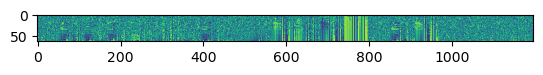

In [66]:
img = cv2.imread('116.png',10)
plt.imshow(img)
img = np.expand_dims(img, axis=2)
print('Image Dimensions :', img.shape)
plt.show()

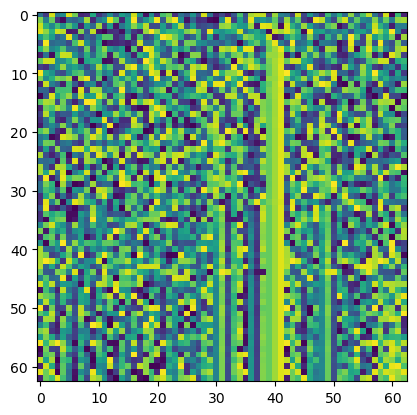

In [67]:
resize = tf.image.resize(img, (63,63))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [68]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 16ms/step


In [69]:
yhat


array([[0.25010547, 0.01600879, 0.2743572 , 0.45952854]], dtype=float32)

In [74]:
if np.argmax(yhat) == 0: 
    print(f'Predicted class is GNAW')
elif np.argmax(yhat) == 1:
    print(f'Predicted class is KNEW')
elif np.argmax(yhat) == 2:
    print(f'Predicted class is PAT')
elif np.argmax(yhat) == 3:
    print(f'Predicted class is POT')
else:
    print(f'Error')
    

    


Predicted class is POT
